# We import all public/external libraries and set runtime flags in one place for easy maintanence. 

In [27]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # force CPU-only (reproducible, no CUDA dependency); remove to use GPU

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import layers, Sequential
import tensorflow as tf
import matplotlib as mpl

# Project Specific Functions - All the necessary customs functions for our projects are defined in this cell. Many print functions are called to track logs. 

In [28]:
def load_dataset(csv_features, csv_targets):
    """
    Loads features and targets from two CSV files and returns a single array
    where the last column is the target. Assumes comma-delimited files with no
    headers.

    Parameters:
        csv_features : str -> Path to CSV containing numeric features (no header).
        csv_targets : str ->Path to CSV containing numeric targets (no header).

    Returns:
        data : ndarray, shape (N, F(20)+1) -> combined array where the last column is the target.
    """
    print("Loading dataset...")
    features = np.genfromtxt(csv_features, delimiter=',')
    targets = np.genfromtxt(csv_targets, delimiter=',').reshape(-1, 1)
    data = np.concatenate((features, targets), axis=1)
    print(data)
    print(f"Features shape: {features.shape}, Targets shape: {targets.shape}, Combined: {data.shape}\n")
    return data

def split_data(data):
    """
    Splits the combined array into train/val/test with a deterministic 80/10/10 percentage,
    then separates each into X (features) and y (target). 
    Parameters:
        data: ndarray -> the array we want to split with features in all columns except the last.

    Returns:
        x_train, y_train, x_val, y_val, x_test, y_test
    """    
    split1 = int(0.8 * len(data))
    split2 = int(0.9 * len(data))
    train = data[:split1]
    val = data[split1:split2]
    test = data[split2:]
    return train[:, :-1], train[:, -1], val[:, :-1], val[:, -1], test[:, :-1], test[:, -1]        

def remove_duplicate_and_complement_rows(data):
    """
    Drops duplicate entries by treating a feature row and its bitwise complement as the
    same pattern. We keep the first occurrence and discard any exact duplicates
    or complements that show up later even if they have slightly different target values.

    Parameters:
        data: ndarray -> features in all columns except the last.

    Returns:
        ndarray removing duplicates and their complement-duplicates.
    """
    seen = {} # key -> (feature vector, target, original_bitstring)
    unique_rows = []
    for i, row in enumerate(data):
        """
        At first storing the features and target separately and turning each feature row 
        into a bitstring like "010101". Then building its complement ("101010") and pick the smaller of the two strings
        as the canonical key. Keeping the first time a key appears and dropping the rest.
        """
        features = row[:-1].astype(int)            
        target = row[-1]   

        feature_str = ''.join(map(str, features))  
        complement_str = ''.join('1' if bit == '0' else '0' for bit in feature_str)  
        key = min(feature_str, complement_str)   

        if key in seen:
            existing_features, existing_target, source_str = seen[key]

            # Found potential duplicate
            if np.array_equal(features, existing_features):
                print(f"\n[Duplicate] Row {i} is exact duplicate of earlier row with same target.\n existing feature = {existing_features}\n Target value: existing target = {target} vs source target = {existing_target}\n")
                continue  # Skip this row
        else:
            seen[key] = (features.copy(), target, feature_str)
            #print(f"seen values = {seen}")
        unique_rows.append(row)

    return np.array(unique_rows)

def build_model(input_dim, seed):
    """
    Defining our model architecture with a seeded normal
    initializer.

    Parameters:
        input_dim: Number of input features. For our project it is 20.
        seed: Random seed for weight initialization. We have used total 10 seed values which can be found later. 

    Returns:
        A tf.keras.Sequential model (uncompiled).
    """
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=seed)
 
    return Sequential([
            layers.Dense(480, activation='relu', input_shape=(input_dim,), kernel_initializer=initializer),
            layers.Dropout(0.2),
            layers.Dense(512, activation='relu', kernel_initializer=initializer),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu', kernel_initializer=initializer),
            layers.Dropout(0.2),
            layers.Dense(1, activation='linear', kernel_initializer=initializer)
        ])

def train_model(model, x_train, y_train, x_val, y_val, model_path, weight_path, plot_path):
    """
    Compiles the model with MSE and AdamW, then trains for up to 2000 epochs
    with EarlyStopping and best-model checkpointing (monitored by val_loss).
    After training, saves the weights.
   
    Parameters:
        model: Our Keras model.
        x_train, y_train: Training data (feature, target).
        x_val, y_val: Validation data for early stopping/model selection.
        model_path: Filepath to save the best model (by val_loss).
        weight_path: Filepath to save best weights.
    """
    model.compile(loss='mean_squared_error', optimizer=AdamW(learning_rate=1e-4), metrics=['mean_squared_error'])
    callbacks = [
        ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_loss', mode='min', verbose=0),
        EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True, verbose=1),
    ]
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=2000, batch_size=16,
                        verbose=0, shuffle=False,
                        callbacks=callbacks)
    model.save_weights(weight_path)

def get_value(y_test, preds):
    """
    Calculates R² and RMSE for test predictions.

    Parameters:
        y_test: Ground-truth targets.
        preds: Predicted targets on test sets.

    Returns: (r2, rmse) tuple.
    """
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    return r2, rmse


def get_top20(x_test, y_test, preds, top_n=20):
    """
    Compares the N lowest actual values to the N lowest predicted values 
    and saves how many test rows overlap. 
    Also saves matched rows with its correspoding actual and predicted values
    
    Parameters:
    x_test: Test features.
    y_test: Test targets.
    preds: Predicted targets on test sets.
    top_n: Number of top items to compare (default 20).
    
    Returns:
    match_count: Number of overlapping rows.
    matched_set: List of [feature_bitstring, predicted_target, actual_target].
    """
    # Handle edge case where we have fewer samples than top_n
    n = min(top_n, len(y_test))
    
    actual_top_idx = np.argsort(y_test)[:n]
    pred_top_idx = np.argsort(preds)[:n]
    
    matching_indices = sorted(set(actual_top_idx) & set(pred_top_idx))
    match_count = len(matching_indices)
    
    # Save matched top-N datapoints in expected format
    matched_set = []
    for idx in matching_indices:
        combo_str = ''.join(map(str, map(int, x_test[idx])))
        matched_set.append([
            combo_str, 
            f"{preds[idx]:.4f}", 
            f"{y_test[idx]:.4f}"
        ])
    
    return match_count, matched_set

def zero_few_shot_tuning(model_paths, data, val_split, increments, results_dir, model_dir):
    print("\n==== ZERO/FEW-SHOT TUNING STARTED ====")

    # Shuffle at the beginning so val_data (last 10%) is fixed across increments.
    np.random.shuffle(data)

    os.makedirs(results_dir, exist_ok=True)

    # Keeping the last 10% as validation data across all increments. 
    val_size = int(val_split * len(data))
    val_data = data[-val_size:]
    x_val, y_val = val_data[:, :-1], val_data[:, -1]

    # Separating train-test data from full data
    tt_len = len(data) - val_size
    tt_data = data[:tt_len]

    # csv file to save train, valid and test data size for each increments
    split_csv = os.path.join(results_dir, "Data_size.csv")
    with open(split_csv, 'w') as f:
        f.write('Increment (%),Train Size,Test Size,Validation Size\n')

    match_counts = []
    avg_r2_list = []
    avg_rmse_list = []
    train_size_list = []

    # Iterate over training percentage
    for inc in increments:
        inc_pct = int(inc * 100) 
        print(f"\n--- Training with {inc_pct}% of trainable pool ---")

        # Compute train size from the train-test data
        train_len = int(round(inc * tt_len)) if inc > 0 else 0
        if train_len > tt_len:
            train_len = tt_len

        # Train/Test split from tt_data
        if train_len > 0:
            train_data = tt_data[:train_len]
            x_train, y_train = train_data[:, :-1], train_data[:, -1]
        else:
            train_data = np.empty((0, data.shape[1]))
            x_train = np.empty((0, data.shape[1] - 1))
            y_train = np.empty((0,))

        test_data = tt_data[train_len:]
        x_test, y_test = test_data[:, :-1], test_data[:, -1]

        # Log split sizes
        with open(split_csv, 'a') as f:
            f.write(f"{inc_pct},{train_data.shape[0]},{test_data.shape[0]},{val_data.shape[0]}\n")

        # Container for each increment
        predictions = []
        per_model_r2 = []
        per_model_rmse = []

        """
        For each checkpoint in `model_paths` (one per seed), we:
        1) Load and compile the pre-trained model.
        2) If this increment has training data (train_len > 0), fine-tune on (x_train, y_train)
            using early stopping against (x_val, y_val), and save the best weights for this seed+increment.
        3) Run predictions on x_test.
        4) Compute this model’s R² and RMSE on y_test.
        5) Keep the prediction vector so, after looping all seeds, we can:
            • ensemble by averaging aligned predictions, and
            • measure “top-20” overlap (lowest actual vs. lowest predicted) and save matched rows.
        """
        for path in model_paths:
            seed_match = re.search(r'seed(\d+)', os.path.basename(path))
            seed_str = seed_match.group(1) if seed_match else "NA"

            print(f"\n Running model (seed {seed_str})")
            print(f"   Train: {train_data.shape[0]} | Val: {val_data.shape[0]} | Test: {test_data.shape[0]}")
            print(f"   Loading from {path}")

            model = load_model(path)
            model.compile(loss='mse', optimizer=AdamW(1e-4), metrics=['mse'])

            # Few-shot fine-tuning if train_len > 0
            if train_len > 0:
                es = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=0)
                ckpt_path = os.path.join(model_dir, f"Dense_model_seed{seed_str}_inc{inc_pct}.keras")
                ckpt = ModelCheckpoint(filepath=ckpt_path, save_best_only=True, verbose=0)
                model.fit(
                    x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=1000,
                    batch_size=16,
                    verbose=0,
                    callbacks=[es, ckpt]
                )
            else:
                print(f"\nSkipping training for 0% increment (seed {seed_str}).")

            # Predict on test
            y_pred = model.predict(x_test, verbose=0).squeeze()
            predictions.append(y_pred)

            r2 = r2_score(y_test, y_pred)
            rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
            
            per_model_r2.append(r2)
            per_model_rmse.append(rmse)

        # Average metrics across models for this increment
        avg_r2 = float(np.nanmean(per_model_r2)) if per_model_r2 else np.nan
        avg_rmse = float(np.nanmean(per_model_rmse)) if per_model_rmse else np.nan

        # Store and print (upto 4 decimals)
        train_size_list.append(train_data.shape[0])
        avg_r2_list.append(avg_r2)
        avg_rmse_list.append(avg_rmse)
        print(f"Increment {inc_pct}% | Train={train_data.shape[0]} | "
              f"Val={val_data.shape[0]} | Test={test_data.shape[0]} | "
              f"Avg R² = {avg_r2:.4f} | Avg RMSE = {avg_rmse:.4f}")

        # Finding topN matches
        if len(test_data) > 0 and predictions:
            # Check if all predictions have the same length as test data
            valid_preds = [p for p in predictions if len(p) == len(y_test)]
            
            if len(valid_preds) > 0:
                # Simple ensemble averaging with valid predictions only
                avg_pred = np.mean(valid_preds, axis=0)
                top_n = min(20, len(test_data))
                
                # Calling get_top20 function to get number of topN matches and the matched set
                match_count, matched_set = get_top20(x_test, y_test, avg_pred, top_n)
                match_counts.append((inc_pct, match_count))
                print(f" Match count: {match_count}")
                
                # Converting matched_set to DataFrame format and save
                if matched_set:
                    # Converting string format back to float for proper rounding
                    matched_data = []
                    for combo_str, pred_str, actual_str in matched_set:
                        matched_data.append({
                            '20-bit Combination': combo_str,
                            'Avg_pred_target': float(pred_str),
                            'Actual_target': float(actual_str)
                        })
                    
                    result_csv = os.path.join(results_dir, f"increment{inc_pct}_matched_results.csv")
                    pd.DataFrame(matched_data).round({'Avg_pred_target': 4, 'Actual_target': 4}) \
                        .to_csv(result_csv, index=False)
                    print(f" Saved matched results: {result_csv}")
            else:
                match_counts.append((inc_pct, 0))
                print(f" Match count: 0 (no valid predictions)")
        else:
            match_counts.append((inc_pct, 0))
            print(f" Match count: 0 (no test data or predictions)")

    # Saving match counts
    match_counts_csv = os.path.join(results_dir, 'match_counts_summary.csv')
    pd.DataFrame(match_counts, columns=['Increment (%)', 'Match Count']).to_csv(match_counts_csv, index=False)
    print(f"Saved match counts summary: {match_counts_csv}")

    # Saving per-increment avg metrics with Train_Data_Size, rounded to 4 decimals
    metrics_df = pd.DataFrame({
        'Train_Data_Size': train_size_list,
        'Avg_R2': avg_r2_list,
        'Avg_RMSE': avg_rmse_list,
    }).round({'Avg_R2': 4, 'Avg_RMSE': 4})

    metrics_csv = os.path.join(results_dir, 'avg_metrics_summary.csv')
    metrics_df.to_csv(metrics_csv, index=False)
    print(f"Saved average metrics summary: {metrics_csv}")

    print("✅ All increments completed successfully.")

# Train on Dataset1 & Dataset2. 
This cell runs an end-to-end training/evaluation loop on **one chosen dataset** (by default: Dataset2 = 90–50; uncomment Block 1 to use Dataset1 = Compsequences).

- **Setup & data:** Makes the output folders, loads the feature/target CSVs, combines them, and removes duplicates by treating a feature vector and its **bitwise complement** as the same **canonical** pattern (keep the first one).
- **Per-seed runs (10 seeds):** For each seed we shuffle once, split the data **80/10/10**, build a small DNN, train with **MSE + AdamW** and **EarlyStopping** (saving the best model), then predict on the test set.
- **Metrics:** We compute **R²** and **RMSE** per seed and save them to `seed_metrics.csv`.
- **Top-20 check:** For each seed we compare the **20 lowest** actual targets to the **20 lowest** predicted targets (same row indices), save the matched rows to `Predictions/seed_{seed}_top20_matched_results.csv`, and log counts in `match_count_per_seed.csv`.
- **Outputs:** Best models go to `models_dir`, weights to `weights_dir`, and plots to `results_dir/Plots/`.

We can get per-seed performance and can inspect whether the model consistently recovers the lowest-target compounds.

In [29]:
# Paths & experiment setup
# Keeping all file paths here so runs are easy to reproduce/change.
# Note: compsequences = Dataset1, 90-50 = Dataset2 in the paper.
# uncomment exactly one block to choose a dataset

# # Block 1
# # Dataset1(compsequences)
# csv_feat = "/home/nishat_labiba/Research USF/Project Material Data/Datasets/compsequences.csv"
# csv_out = "/home/nishat_labiba/Research USF/Project Material Data/Datasets/compfitness.csv"
# results_dir = f'/home/nishat_labiba/Research USF/Project Material Data/Results/Compsequences(original)/Train_on_main_dataset'
# models_dir = f'/home/nishat_labiba/Research USF/Project Material Data/Models/Compsequences(original)/Train_on_main_dataset'
# weights_dir = f'/home/nishat_labiba/Research USF/Project Material Data/Weights/Compsequences(original)/Train_on_main_dataset'
# # End Block 1

# Block 2
# Dataset2(90-50)
csv_feat = "/home/nishat_labiba/Research USF/Project Material Data/Datasets/Compatibilizers-90-50-features.csv"
csv_out = "/home/nishat_labiba/Research USF/Project Material Data/Datasets/Compatibilizers-90-50output.csv"
results_dir = f'/home/nishat_labiba/Research USF/Project Material Data/Results/90-50/Train_on_main_dataset'
models_dir = f'/home/nishat_labiba/Research USF/Project Material Data/Models/90-50/Train_on_main_dataset'
weights_dir = f'/home/nishat_labiba/Research USF/Project Material Data/Weights/90-50/Train_on_main_dataset'
# End block 2

pred_dir = os.path.join(results_dir, "Predictions")

os.makedirs(results_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(pred_dir, exist_ok=True)

# loading original data and cleaning duplicate entries
data = load_dataset(csv_feat, csv_out)
cleaned_data = remove_duplicate_and_complement_rows(data)
print(f"Original data shape: {data.shape}")
print(f"Cleaned data shape: {cleaned_data.shape}")
data = cleaned_data
print(f"Final data shape: {data.shape}")

# Ten seeds (prime number) for reproducibility and ensembling
seeds = [5, 17, 29, 43, 53, 311, 331, 631, 719, 769]

all_seed_metrics = []         # (seed, R2, RMSE)
all_seed_match_counts = []    # (seed, Top20_Match)
n=0

"""
For each seed we are shuffling(once) 
splitting, building, training, evaluating, and saving predictions
"""
for seed in seeds:
    np.random.seed(seed)
    shuffled = np.random.permutation(data)
    x_train, y_train, x_val, y_val, x_test, y_test = split_data(shuffled)

    print(f"Train: {len(x_train)} | Val: {len(x_val)} | Test: {len(x_test)}")
    print(f"\nTraining model {n+1} with seed {seed}...")
    n += 1

    model = build_model(x_train.shape[1], seed)

    model_name = f"Dense_model_seed{seed}"

    model_path = os.path.join(models_dir, f"{model_name}.keras")
    weight_path = os.path.join(weights_dir, f"{model_name}.weights.h5")
    plot_path = os.path.join(results_dir, f"Plots/{model_name}")
    os.makedirs(plot_path, exist_ok=True)


    train_model(model, x_train, y_train, x_val, y_val, model_path, weight_path, plot_path)

    # Evaluate after training
    preds = model.predict(x_test).flatten()

    r2, rmse = get_value(y_test, preds)
    all_seed_metrics.append(( seed, r2, rmse))
    print(f"Seed {seed} | R² = {r2:.4f} | RMSE = {rmse:.4f}")

    # Top-20 analysis 
    match_count, matched_set = get_top20(x_test, y_test, preds, 20)
    all_seed_match_counts.append((seed, match_count))

    cols = ["20-bit Combination", "Pred_Target", "Actual_Target"]
    matched_df = pd.DataFrame(matched_set, columns=cols)

    # rounding numeric columns to 4 decimal places
    num_cols = ["Pred_Target", "Actual_Target"]
    matched_df[num_cols] = matched_df[num_cols].astype(float).round(4)

    # saving with 4-decimal formatting
    out_path = os.path.join(pred_dir, f"seed_{seed}_top20_matched_results.csv")
    matched_df.to_csv(out_path, index=False, float_format="%.4f")

    print(f"\nTotal Top-20 Matches in Seed {seed} : {match_count}")
    print(f"Saved rounded matched-set to: {out_path}")

pd.DataFrame(all_seed_metrics, columns=["Seed", "R2", "RMSE"]).round({'R2': 3, 'RMSE': 3}).to_csv(os.path.join(results_dir, "seed_metrics.csv"), index=False)
pd.DataFrame(all_seed_match_counts, columns=["Seed", "Top20_Match"]).to_csv(os.path.join(results_dir, "match_count_per_seed.csv"), index=False)

Loading dataset...
[[0.       1.       1.       ... 0.       1.       0.852791]
 [0.       1.       1.       ... 0.       1.       0.874634]
 [0.       1.       1.       ... 0.       1.       0.875778]
 ...
 [0.       0.       0.       ... 0.       0.       1.63684 ]
 [0.       0.       0.       ... 0.       0.       1.65938 ]
 [1.       1.       1.       ... 0.       0.       1.75214 ]]
Features shape: (1632, 20), Targets shape: (1632, 1), Combined: (1632, 21)

Original data shape: (1632, 21)
Cleaned data shape: (1632, 21)
Final data shape: (1632, 21)
Train: 1305 | Val: 163 | Test: 164

Training model 1 with seed 5...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 703: early stopping
Restoring model weights from the end of the best epoch: 503.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Seed 5 | R² = 0.9150 | RMSE = 0.0383

Total Top-20 Matches in Seed 5 : 12
Saved rounded matched-set to: /home/nishat_labiba/Research USF/Project Material Data/Results/90-50/Train_on_main_dataset/Predictions/seed_5_top20_matched_results.csv
Train: 1305 | Val: 163 | Test: 164

Training model 2 with seed 17...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 714: early stopping
Restoring model weights from the end of the best epoch: 514.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Seed 17 | R² = 0.9095 | RMSE = 0.0388

Total Top-20 Matches in Seed 17 : 14
Saved rounded matched-set to: /home/nishat_labiba/Research USF/Project Material Data/Results/90-50/Train_on_main_dataset/Predictions/seed_17_top20_matched_results.csv
Train: 1305 | Val: 163 | Test: 164

Training model 3 with seed 29...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 929: early stopping
Restoring model weights from the end of the best epoch: 729.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Seed 29 | R² = 0.9159 | RMSE = 0.0409

Total Top-20 Matches in Seed 29 : 15
Saved rounded matched-set to: /home/nishat_labiba/Research USF/Project Material Data/Results/90-50/Train_on_main_dataset/Predictions/seed_29_top20_matched_results.csv
Train: 1305 | Val: 163 | Test: 164

Training model 4 with seed 43...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 782: early stopping
Restoring model weights from the end of the best epoch: 582.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Seed 43 | R² = 0.9387 | RMSE = 0.0355

Total Top-20 Matches in Seed 43 : 15
Saved rounded matched-set to: /home/nishat_labiba/Research USF/Project Material Data/Results/90-50/Train_on_main_dataset/Predictions/seed_43_top20_matched_results.csv
Train: 1305 | Val: 163 | Test: 164

Training model 5 with seed 53...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 785: early stopping
Restoring model weights from the end of the best epoch: 585.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Seed 53 | R² = 0.9260 | RMSE = 0.0353

Total Top-20 Matches in Seed 53 : 12
Saved rounded matched-set to: /home/nishat_labiba/Research USF/Project Material Data/Results/90-50/Train_on_main_dataset/Predictions/seed_53_top20_matched_results.csv
Train: 1305 | Val: 163 | Test: 164

Training model 6 with seed 311...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 576: early stopping
Restoring model weights from the end of the best epoch: 376.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Seed 311 | R² = 0.9002 | RMSE = 0.0463

Total Top-20 Matches in Seed 311 : 14
Saved rounded matched-set to: /home/nishat_labiba/Research USF/Project Material Data/Results/90-50/Train_on_main_dataset/Predictions/seed_311_top20_matched_results.csv
Train: 1305 | Val: 163 | Test: 164

Training model 7 with seed 331...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 880: early stopping
Restoring model weights from the end of the best epoch: 680.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Seed 331 | R² = 0.8988 | RMSE = 0.0415

Total Top-20 Matches in Seed 331 : 16
Saved rounded matched-set to: /home/nishat_labiba/Research USF/Project Material Data/Results/90-50/Train_on_main_dataset/Predictions/seed_331_top20_matched_results.csv
Train: 1305 | Val: 163 | Test: 164

Training model 8 with seed 631...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 906: early stopping
Restoring model weights from the end of the best epoch: 706.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Seed 631 | R² = 0.9289 | RMSE = 0.0386

Total Top-20 Matches in Seed 631 : 17
Saved rounded matched-set to: /home/nishat_labiba/Research USF/Project Material Data/Results/90-50/Train_on_main_dataset/Predictions/seed_631_top20_matched_results.csv
Train: 1305 | Val: 163 | Test: 164

Training model 9 with seed 719...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 834: early stopping
Restoring model weights from the end of the best epoch: 634.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Seed 719 | R² = 0.9370 | RMSE = 0.0394

Total Top-20 Matches in Seed 719 : 16
Saved rounded matched-set to: /home/nishat_labiba/Research USF/Project Material Data/Results/90-50/Train_on_main_dataset/Predictions/seed_719_top20_matched_results.csv
Train: 1305 | Val: 163 | Test: 164

Training model 10 with seed 769...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 819: early stopping
Restoring model weights from the end of the best epoch: 619.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Seed 769 | R² = 0.9114 | RMSE = 0.0419

Total Top-20 Matches in Seed 769 : 13
Saved rounded matched-set to: /home/nishat_labiba/Research USF/Project Material Data/Results/90-50/Train_on_main_dataset/Predictions/seed_769_top20_matched_results.csv


# Zero and Few Shot Tuning On Target Dataset
We run a **zero-/few-shot transfer** study between the two datasets.

- **Pick a direction.** Keep **one** block active:
  1) Dataset1 (Compsequences) -> Dataset2 (90–50), or  
  2) Dataset2 (90–50) -> Dataset1 (Compsequences).
- **Load target data:** Read the chosen target dataset (features + targets).
- **Collect source models:** Grab the **10** pretrained `.keras` checkpoints from the source directory.
- **Set the schedule:** Define training fractions `increments = [0%, 5%, …, 80%]`  
  (0% = pure **zero-shot**; >0% = **few-shot** fine-tuning).
- **Run tuning:** `zero_few_shot_tuning(...)` shuffles once, holds out **10%** for validation,
  then for each increment it:
  - fine-tunes each source model on the target train slice (skips at 0%),
  - evaluates on a fixed test split,
  - aggregates metrics (**R²**, **RMSE**), and
  - computes a simple **Top-N** overlap (lowest actual vs. lowest predicted).
- **Outputs:** Metrics/overlaps are written under `results_dir` (CSV files),
  and the fine-tuned checkpoints are saved into `models_dir`.

The results compare zero-shot vs few-shot performance as we increase the amount of target training data.

In [ ]:
# 
""" 
At first we will load the target dataset and will pick 10 pre-trained source models.
Then we will run zero and few shot tuning across increasing train sizes.
We need to keep exactly one block active to perform this part. 
1. Block 1: Dataset1 (Compsequences) → Dataset2 (90-50) 
2. BLock 2: Dataset2 (90-50) → Dataset1 (Compsequences) 
"""

# # Block 1
# # We will evaluate/tune on the Dataset2 (90-50 dataset).
# target_feat = "/home/nishat_labiba/Research USF/Project Material Data/Datasets/Compatibilizers-90-50-features.csv"
# target_out  = "/home/nishat_labiba/Research USF/Project Material Data/Datasets/Compatibilizers-90-50output.csv"
# target_data = load_dataset(target_feat, target_out)

# # Source models pretrained on Dataset1 (Compsequences)
# # Starting from the 10 models trained on Dataset1 (Compsequences) and adapt them to Dataset2 (90-50).
# tune_model_dir = "/home/nishat_labiba/Research USF/Project Material Data/Models/Compsequences(original)/Train_on_main_dataset"

# # Path to write tuning results and the fine-tuned checkpoints for Dataset2 (90-50).
# result_dir = "/home/nishat_labiba/Research USF/Project Material Data/Results/90-50/Tuning on Compsequences(original)"
# models_dir = "/home/nishat_labiba/Research USF/Project Material Data/Models/90-50/Tuning on Compsequences(original)"
# # End Block 1

# Block 2
# We will evaluate/tune on the Dataset1 (compsequences).
target_feat = "/home/nishat_labiba/Research USF/Project Material Data/Datasets/compsequences.csv"
target_out  = "/home/nishat_labiba/Research USF/Project Material Data/Datasets/compfitness.csv"
target_data = load_dataset(target_feat, target_out)

# Source models pretrained on Dataset2 (90-50)
# Starting from the 10 models trained on Dataset2 (90-50) and adapt them to Dataset1 (compsequences).
tune_model_dir = "/home/nishat_labiba/Research USF/Project Material Data/Models/90-50/Train_on_main_dataset"
#
# Path to write tuning results and the fine-tuned checkpoints for Dataset1 (compsequences).
result_dir = "/home/nishat_labiba/Research USF/Project Material Data/Results/Compsequences(original)/Tuning on 90-50"
models_dir = "/home/nishat_labiba/Research USF/Project Material Data/Models/Compsequences(original)/Tuning on 90-50"
# End Block 2

# sorting the 10 pre-trained models.
model_paths = sorted(
    os.path.join(tune_model_dir, f)
    for f in os.listdir(tune_model_dir)
    if f.endswith(".keras")
)[:10]

os.makedirs(models_dir, exist_ok=True)  # fine-tuned checkpoints will be saved here

# array to store the zero/few shot increment percentage
# 0% = pure zero-shot
increments = [0.0, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80]

# Function to run zero-few shot tuning
zero_few_shot_tuning(
    model_paths=model_paths,
    data=target_data,
    val_split=0.1,
    increments=increments,
    results_dir=result_dir,
    model_dir=models_dir
)

Loading dataset...
[[0.       1.       1.       ... 0.       1.       0.852791]
 [0.       1.       1.       ... 0.       1.       0.874634]
 [0.       1.       1.       ... 0.       1.       0.875778]
 ...
 [0.       0.       0.       ... 0.       0.       1.63684 ]
 [0.       0.       0.       ... 0.       0.       1.65938 ]
 [1.       1.       1.       ... 0.       0.       1.75214 ]]
Features shape: (1632, 20), Targets shape: (1632, 1), Combined: (1632, 21)


==== ZERO/FEW-SHOT TUNING STARTED ====

--- Training with 0% of trainable pool ---

 Running model (seed 17)
   Train: 0 | Val: 163 | Test: 1469
   Loading from /home/nishat_labiba/Research USF/Project Material Data/Models/Compsequences(original)/Train_on_main_dataset/Dense_model_seed17.keras

Skipping training for 0% increment (seed 17).

 Running model (seed 29)
   Train: 0 | Val: 163 | Test: 1469
   Loading from /home/nishat_labiba/Research USF/Project Material Data/Models/Compsequences(original)/Train_on_main_dataset/Dense

# Varying train size, no fine-tuning

This cell measures how performance scales **when training from scratch** as we give the model more data on **one chosen dataset** (by default: Dataset2 = 90–50; uncomment Block 1 to use Dataset1 = Compsequences).

- **Setup & data:** Makes the output folders, loads the feature/target CSVs, combines them, and removes duplicates by treating a feature vector and its **bitwise complement** as the same **canonical** pattern (keep the first one).
- **Train at multiple sizes:** For each train fraction **5% → 80%** and for **10 seeds**:
  - Shuffle once, split **80/10/10** (train/val/test).
  - Subsample the training split to the current fraction.
  - Build a small deep feed-forward network (MLP), train with **MSE + AdamW** and **EarlyStopping**, then evaluate on the test set.
- **Aggregate results:** Average **R²** and **RMSE** across the 10 seeds for each fraction and record the actual train size used.
- **Outputs:** A summary table is written to  
  `results_dir/percent_training_without_tuning_results.csv`, and per-run models/weights/plots are saved under the corresponding folders.

It is used to create the **data-scaling baseline** (no pretraining) that we can compare against our zero/few-shot fine-tuning results.


In [ ]:
# Paths & experiment setup
# Keeping all file paths here so runs are easy to reproduce/change.
# Note: compsequences = Dataset1, 90-50 = Dataset2 in the paper.
# uncomment exactly one block to choose a dataset

# Block 1
# Dataset1(compsequences)
csv_feat = "/home/nishat_labiba/Research USF/Project Material Data/Datasets/compsequences.csv"
csv_out = "/home/nishat_labiba/Research USF/Project Material Data/Datasets/compfitness.csv"
results_dir = f'/home/nishat_labiba/Research USF/Project Material Data/Results/Compsequences(original)/Train_on_main_dataset_varying_train_data'
models_dir = f'/home/nishat_labiba/Research USF/Project Material Data/Models/Compsequences(original)/Train_on_main_dataset_varying_train_data'
weights_dir = f'/home/nishat_labiba/Research USF/Project Material Data/Weights/Compsequences(original)/Train_on_main_dataset_varying_train_data'
# End Block 1

# # Block 2
# # Dataset2(90-50)
# csv_feat = "/home/nishat_labiba/Research USF/Project Material Data/Datasets/Compatibilizers-90-50-features.csv"
# csv_out = "/home/nishat_labiba/Research USF/Project Material Data/Datasets/Compatibilizers-90-50output.csv"
# results_dir = f'/home/nishat_labiba/Research USF/Project Material Data/Results/90-50/Train_on_main_dataset_varying_train_data'
# models_dir = f'/home/nishat_labiba/Research USF/Project Material Data/Models/90-50/Train_on_main_dataset_varying_train_data'
# weights_dir = f'/home/nishat_labiba/Research USF/Project Material Data/Weights/90-50/Train_on_main_dataset_varying_train_data'
# # End block 2

pred_dir = os.path.join(results_dir, "Predictions")

os.makedirs(results_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(pred_dir, exist_ok=True)

# loading original data and cleaning duplicate entries
data = load_dataset(csv_feat, csv_out)
cleaned_data = remove_duplicate_and_complement_rows(data)
print(f"Original data shape: {data.shape}")
print(f"Cleaned data shape: {cleaned_data.shape}")
data = cleaned_data
print(f"Final data shape: {data.shape}")

# Seed and increment array
seeds = [5, 17, 29, 43, 53, 311, 331, 631, 719, 769]
increments = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80]

avg_r2_scores = []
avg_rmse_scores = []
train_data_sizes = []
n=0

# Iterate over training percentage
for inc in increments:
    r2_scores = []
    rmse_scores = []
    n += 1

    # For each seed we are shuffling(once) and then splitting, building, training, evaluating, and saving predictions
    for seed in seeds:
        np.random.seed(seed)
        shuffled = np.random.permutation(data)
        x_train_full, y_train_full, x_val, y_val, x_test, y_test = split_data(shuffled)

        # Subsample the training slice according to the current increment
        train_size = int(len(x_train_full) * inc)
        x_train = x_train_full[:train_size]
        y_train = y_train_full[:train_size]

        print(f"Train Full: {len(x_train_full)} | Train: {len(x_train)} | Val: {len(x_val)} | Test: {len(x_test)}")
        print(f"\nTraining model {n} with increment {inc*100}% and seed {seed}...")

        model = build_model(x_train.shape[1], seed)

        model_name = f"Dense_model_seed{seed}_inc{inc*100}"

        model_path = os.path.join(models_dir, f"{model_name}.keras")
        weight_path = os.path.join(weights_dir, f"{model_name}.weights.h5")
        plot_path = os.path.join(results_dir, f"Plots/{model_name}")
        os.makedirs(plot_path, exist_ok=True)

        # Train with early stopping & best-checkpoint saving
        train_model(model, x_train, y_train, x_val, y_val, model_path, weight_path, plot_path)

        # Evaluate model after training
        preds = model.predict(x_test).flatten()
        r2, rmse = get_value(y_test, preds)
        r2_scores.append(r2)
        rmse_scores.append(rmse)
        print(f"✅ Seed {seed} | R² = {r2:.4f} | RMSE = {rmse:.4f}")

    # Average across all seeds for this increment
    avg_r2_scores.append(np.mean(r2_scores))
    avg_rmse_scores.append(np.mean(rmse_scores))
    train_data_sizes.append(len(x_train))
    print(f'train data size: {len(x_train)} | avg_r2 = {np.mean(r2_scores)} | avg_rmse = {np.mean(rmse_scores)}')

    # Saving the summary table for this increment
    results_df = pd.DataFrame({
        "Train_Data_Size": train_data_sizes,
        "Avg_R2": avg_r2_scores,
        "Avg_RMSE": avg_rmse_scores
    })

# Round R² and RMSE to 4 decimal places
results_df = results_df.round({"Avg_R2": 4, "Avg_RMSE": 4})
csv_output_path = os.path.join(results_dir, "percent_training_without_tuning_results.csv")
results_df.to_csv(csv_output_path, index=False)

print(f"\n✅ Results saved to {csv_output_path}")

Loading dataset...
[[0.     0.     0.     ... 1.     0.     0.8273]
 [0.     0.     1.     ... 1.     0.     0.6748]
 [1.     0.     1.     ... 1.     0.     0.9175]
 ...
 [1.     0.     0.     ... 1.     0.     0.699 ]
 [0.     1.     0.     ... 1.     0.     0.6684]
 [1.     0.     0.     ... 1.     0.     0.5345]]
Features shape: (3232, 20), Targets shape: (3232, 1), Combined: (3232, 21)

Original data shape: (3232, 21)
Cleaned data shape: (3232, 21)
Final data shape: (3232, 21)
Train Full: 2585 | Train: 129 | Val: 323 | Test: 324

Training model 1 with increment 5.0% and seed 5...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1808: early stopping
Restoring model weights from the end of the best epoch: 1608.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 5 | R² = 0.3054 | RMSE = 0.1677
Train Full: 2585 | Train: 129 | Val: 323 | Test: 324

Training model 1 with increment 5.0% and seed 17...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 345: early stopping
Restoring model weights from the end of the best epoch: 145.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 17 | R² = -0.0887 | RMSE = 0.1968
Train Full: 2585 | Train: 129 | Val: 323 | Test: 324

Training model 1 with increment 5.0% and seed 29...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 891: early stopping
Restoring model weights from the end of the best epoch: 691.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 29 | R² = 0.2043 | RMSE = 0.1803
Train Full: 2585 | Train: 129 | Val: 323 | Test: 324

Training model 1 with increment 5.0% and seed 43...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1673: early stopping
Restoring model weights from the end of the best epoch: 1473.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 43 | R² = 0.1603 | RMSE = 0.1688
Train Full: 2585 | Train: 129 | Val: 323 | Test: 324

Training model 1 with increment 5.0% and seed 53...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 316: early stopping
Restoring model weights from the end of the best epoch: 116.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 53 | R² = 0.0017 | RMSE = 0.1845
Train Full: 2585 | Train: 129 | Val: 323 | Test: 324

Training model 1 with increment 5.0% and seed 311...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1309: early stopping
Restoring model weights from the end of the best epoch: 1109.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 311 | R² = 0.2442 | RMSE = 0.1786
Train Full: 2585 | Train: 129 | Val: 323 | Test: 324

Training model 1 with increment 5.0% and seed 331...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1151: early stopping
Restoring model weights from the end of the best epoch: 951.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 331 | R² = 0.2250 | RMSE = 0.1797
Train Full: 2585 | Train: 129 | Val: 323 | Test: 324

Training model 1 with increment 5.0% and seed 631...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1231: early stopping
Restoring model weights from the end of the best epoch: 1031.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 631 | R² = -0.0518 | RMSE = 0.1949
Train Full: 2585 | Train: 129 | Val: 323 | Test: 324

Training model 1 with increment 5.0% and seed 719...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1251: early stopping
Restoring model weights from the end of the best epoch: 1051.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 719 | R² = 0.1279 | RMSE = 0.1797
Train Full: 2585 | Train: 129 | Val: 323 | Test: 324

Training model 1 with increment 5.0% and seed 769...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1220: early stopping
Restoring model weights from the end of the best epoch: 1020.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 769 | R² = 0.0903 | RMSE = 0.1828
train data size: 129 | avg_r2 = 0.12186482515859734 | avg_rmse = 0.1813806311992629
Train Full: 2585 | Train: 258 | Val: 323 | Test: 324

Training model 2 with increment 10.0% and seed 5...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1217: early stopping
Restoring model weights from the end of the best epoch: 1017.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 5 | R² = 0.5152 | RMSE = 0.1401
Train Full: 2585 | Train: 258 | Val: 323 | Test: 324

Training model 2 with increment 10.0% and seed 17...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 736: early stopping
Restoring model weights from the end of the best epoch: 536.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 17 | R² = 0.4035 | RMSE = 0.1456
Train Full: 2585 | Train: 258 | Val: 323 | Test: 324

Training model 2 with increment 10.0% and seed 29...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1325: early stopping
Restoring model weights from the end of the best epoch: 1125.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
✅ Seed 29 | R² = 0.4623 | RMSE = 0.1482
Train Full: 2585 | Train: 258 | Val: 323 | Test: 324

Training model 2 with increment 10.0% and seed 43...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 829: early stopping
Restoring model weights from the end of the best epoch: 629.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 43 | R² = 0.4527 | RMSE = 0.1363
Train Full: 2585 | Train: 258 | Val: 323 | Test: 324

Training model 2 with increment 10.0% and seed 53...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1477: early stopping
Restoring model weights from the end of the best epoch: 1277.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 53 | R² = 0.4817 | RMSE = 0.1329
Train Full: 2585 | Train: 258 | Val: 323 | Test: 324

Training model 2 with increment 10.0% and seed 311...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 641: early stopping
Restoring model weights from the end of the best epoch: 441.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 311 | R² = 0.4948 | RMSE = 0.1460
Train Full: 2585 | Train: 258 | Val: 323 | Test: 324

Training model 2 with increment 10.0% and seed 331...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1324: early stopping
Restoring model weights from the end of the best epoch: 1124.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 331 | R² = 0.5358 | RMSE = 0.1391
Train Full: 2585 | Train: 258 | Val: 323 | Test: 324

Training model 2 with increment 10.0% and seed 631...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1712: early stopping
Restoring model weights from the end of the best epoch: 1512.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 631 | R² = 0.4696 | RMSE = 0.1384
Train Full: 2585 | Train: 258 | Val: 323 | Test: 324

Training model 2 with increment 10.0% and seed 719...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1239: early stopping
Restoring model weights from the end of the best epoch: 1039.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 719 | R² = 0.4216 | RMSE = 0.1463
Train Full: 2585 | Train: 258 | Val: 323 | Test: 324

Training model 2 with increment 10.0% and seed 769...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1099: early stopping
Restoring model weights from the end of the best epoch: 899.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 769 | R² = 0.4438 | RMSE = 0.1429
train data size: 258 | avg_r2 = 0.4680988552318057 | avg_rmse = 0.14160003398543955
Train Full: 2585 | Train: 517 | Val: 323 | Test: 324

Training model 3 with increment 20.0% and seed 5...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 728: early stopping
Restoring model weights from the end of the best epoch: 528.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
✅ Seed 5 | R² = 0.6934 | RMSE = 0.1114
Train Full: 2585 | Train: 517 | Val: 323 | Test: 324

Training model 3 with increment 20.0% and seed 17...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 555: early stopping
Restoring model weights from the end of the best epoch: 355.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 17 | R² = 0.7235 | RMSE = 0.0992
Train Full: 2585 | Train: 517 | Val: 323 | Test: 324

Training model 3 with increment 20.0% and seed 29...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 777: early stopping
Restoring model weights from the end of the best epoch: 577.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 29 | R² = 0.6981 | RMSE = 0.1110
Train Full: 2585 | Train: 517 | Val: 323 | Test: 324

Training model 3 with increment 20.0% and seed 43...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1116: early stopping
Restoring model weights from the end of the best epoch: 916.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 43 | R² = 0.6967 | RMSE = 0.1015
Train Full: 2585 | Train: 517 | Val: 323 | Test: 324

Training model 3 with increment 20.0% and seed 53...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 547: early stopping
Restoring model weights from the end of the best epoch: 347.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 53 | R² = 0.6845 | RMSE = 0.1037
Train Full: 2585 | Train: 517 | Val: 323 | Test: 324

Training model 3 with increment 20.0% and seed 311...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 665: early stopping
Restoring model weights from the end of the best epoch: 465.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
✅ Seed 311 | R² = 0.6994 | RMSE = 0.1127
Train Full: 2585 | Train: 517 | Val: 323 | Test: 324

Training model 3 with increment 20.0% and seed 331...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 534: early stopping
Restoring model weights from the end of the best epoch: 334.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 331 | R² = 0.7234 | RMSE = 0.1074
Train Full: 2585 | Train: 517 | Val: 323 | Test: 324

Training model 3 with increment 20.0% and seed 631...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1369: early stopping
Restoring model weights from the end of the best epoch: 1169.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 631 | R² = 0.6656 | RMSE = 0.1099
Train Full: 2585 | Train: 517 | Val: 323 | Test: 324

Training model 3 with increment 20.0% and seed 719...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 891: early stopping
Restoring model weights from the end of the best epoch: 691.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
✅ Seed 719 | R² = 0.6582 | RMSE = 0.1125
Train Full: 2585 | Train: 517 | Val: 323 | Test: 324

Training model 3 with increment 20.0% and seed 769...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 782: early stopping
Restoring model weights from the end of the best epoch: 582.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 769 | R² = 0.6675 | RMSE = 0.1105
train data size: 517 | avg_r2 = 0.6910340116016568 | avg_rmse = 0.10797295574553752
Train Full: 2585 | Train: 775 | Val: 323 | Test: 324

Training model 4 with increment 30.0% and seed 5...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 528: early stopping
Restoring model weights from the end of the best epoch: 328.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 5 | R² = 0.7438 | RMSE = 0.1018
Train Full: 2585 | Train: 775 | Val: 323 | Test: 324

Training model 4 with increment 30.0% and seed 17...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 524: early stopping
Restoring model weights from the end of the best epoch: 324.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 17 | R² = 0.7896 | RMSE = 0.0865
Train Full: 2585 | Train: 775 | Val: 323 | Test: 324

Training model 4 with increment 30.0% and seed 29...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 725: early stopping
Restoring model weights from the end of the best epoch: 525.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
✅ Seed 29 | R² = 0.7595 | RMSE = 0.0991
Train Full: 2585 | Train: 775 | Val: 323 | Test: 324

Training model 4 with increment 30.0% and seed 43...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 728: early stopping
Restoring model weights from the end of the best epoch: 528.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
✅ Seed 43 | R² = 0.7800 | RMSE = 0.0864
Train Full: 2585 | Train: 775 | Val: 323 | Test: 324

Training model 4 with increment 30.0% and seed 53...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 639: early stopping
Restoring model weights from the end of the best epoch: 439.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 53 | R² = 0.7753 | RMSE = 0.0875
Train Full: 2585 | Train: 775 | Val: 323 | Test: 324

Training model 4 with increment 30.0% and seed 311...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 544: early stopping
Restoring model weights from the end of the best epoch: 344.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 311 | R² = 0.7503 | RMSE = 0.1027
Train Full: 2585 | Train: 775 | Val: 323 | Test: 324

Training model 4 with increment 30.0% and seed 331...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 592: early stopping
Restoring model weights from the end of the best epoch: 392.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 331 | R² = 0.7706 | RMSE = 0.0978
Train Full: 2585 | Train: 775 | Val: 323 | Test: 324

Training model 4 with increment 30.0% and seed 631...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 846: early stopping
Restoring model weights from the end of the best epoch: 646.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Seed 631 | R² = 0.7591 | RMSE = 0.0933
Train Full: 2585 | Train: 775 | Val: 323 | Test: 324

Training model 4 with increment 30.0% and seed 719...


/home/nishat_labiba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Plot for Dataset II (90-50)
We plot how performance on **Dataset II (90–50)** scales with training size, comparing:
- **Blue** — models trained **from scratch** on Dataset II.
- **Red** — models **pretrained** on Dataset I (Compsequences) and **fine-tuned** on Dataset II.

For each training size (x-axis), we plot average **R²** and **RMSE** (y-axis) gathered from previous runs.  
The first blue R² point is omitted to avoid a small-sample outlier; all red points are shown.  
Figures are saved to the results folder for inclusion in the paper.


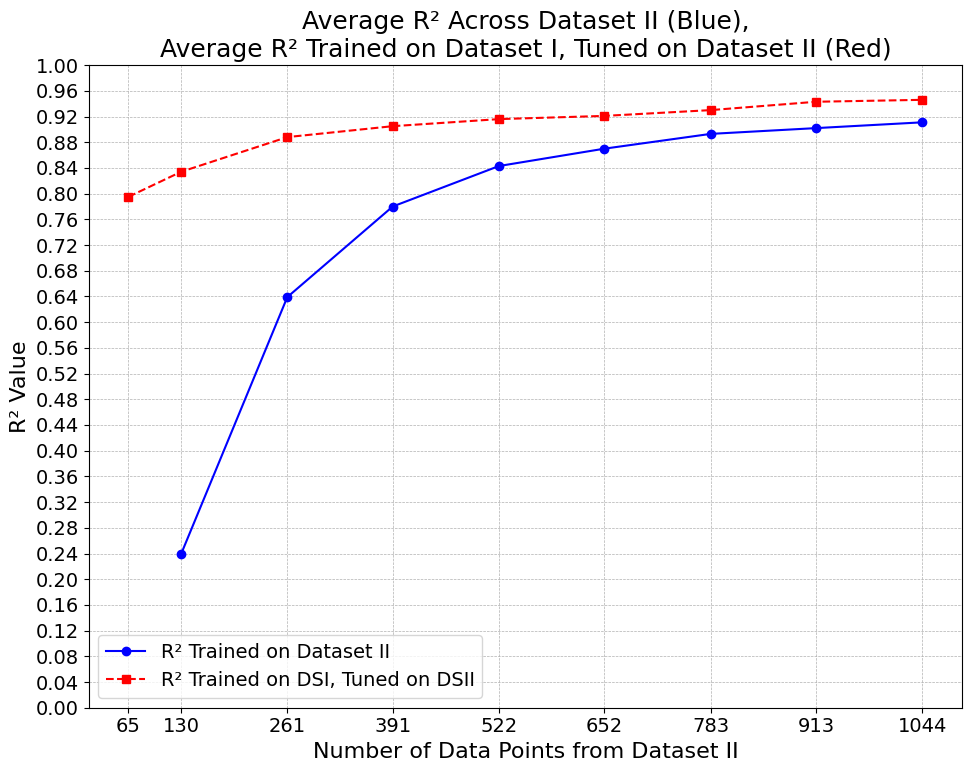

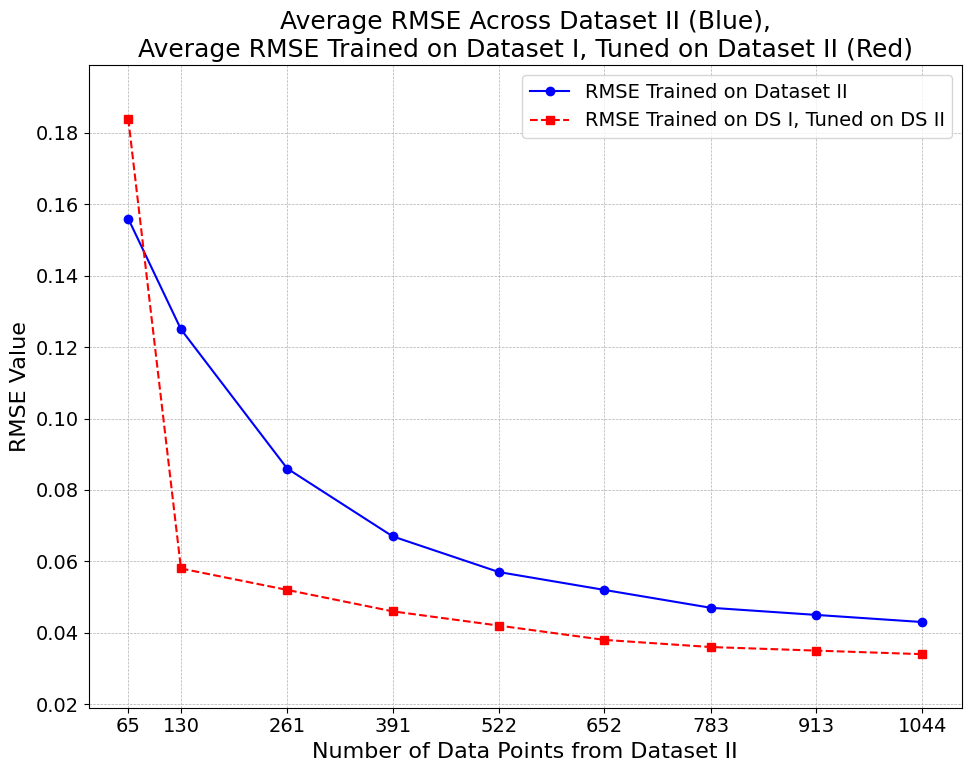

✅ Plots saved to:
/home/nishat_labiba/Research USF/Research Material Data/Results/90-50/percent_training_without_pretrained_model


In [ ]:
# Global font sizes for consistent figure styling
mpl.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
})

# Output directory
results_dir = '/home/nishat_labiba/Research USF/Research Material Data/Results/Compare Avg Metrics With and Without Pretrained Model/90-50'
os.makedirs(results_dir, exist_ok=True)

"""
Metrics for Dataset II (these were exported to CSV in prior runs
and are pasted here directly as arrays for plotting).
"""
# Increasing Training Size
train_data_sizes = np.array([65, 130, 261, 391, 522, 652, 783, 913, 1044])                 

# avg r^2 and RMSE values after training on DSI and tuned on DSII -> Red line
r_squared_values = np.array([0.795, 0.834, 0.888, 0.905, 0.916, 0.921, 0.930, 0.943, 0.946])  
RMSEvalues = np.array([0.184, 0.058, 0.052, 0.046, 0.042, 0.038, 0.036, 0.035, 0.034]) 

# avg r^2 and RMSE values after training on DSII -> Blue line
avg_r2_scores = np.array([-0.178, 0.239, 0.639, 0.780, 0.843, 0.870, 0.893, 0.902, 0.911])
avg_rmse_scores = np.array([0.156, 0.125, 0.086, 0.067, 0.057, 0.052, 0.047, 0.045, 0.043]) 

# --- R² Plot ---
plt.figure(figsize=(10, 8))

# Blue line -> skipping first point as it is a negative value.
plt.plot(train_data_sizes[1:], avg_r2_scores[1:], marker='o', color='blue', label='R² Trained on Dataset II')
# Red line
plt.plot(train_data_sizes, r_squared_values, marker='s', linestyle='--', color='red', label='R² Trained on DSI, Tuned on DSII')

plt.title('Average R² Across Dataset II (Blue),\nAverage R² Trained on Dataset I, Tuned on Dataset II (Red)')
plt.xlabel('Number of Data Points from Dataset II')
plt.ylabel('R² Value')
plt.ylim(0.0, 1.0)

plt.xticks(train_data_sizes)
plt.yticks(np.arange(0, 1.02, 0.04))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f'{results_dir}/combined_avg_r2_scores_d1_to_d2.png')
plt.show()

# --- RMSE Plot ---
y_min = min(RMSEvalues.min(), avg_rmse_scores.min())
y_max = max(RMSEvalues.max(), avg_rmse_scores.max())
y_margin = (y_max - y_min) * 0.1  # 10% margin

plt.figure(figsize=(10, 8))

plt.plot(train_data_sizes, avg_rmse_scores, marker='o', color='blue', label='RMSE Trained on Dataset II')
plt.plot(train_data_sizes, RMSEvalues, marker='s', linestyle='--', color='red', label='RMSE Trained on DS I, Tuned on DS II')

plt.title('Average RMSE Across Dataset II (Blue),\nAverage RMSE Trained on Dataset I, Tuned on Dataset II (Red)')
plt.xlabel('Number of Data Points from Dataset II')
plt.ylabel('RMSE Value')
plt.ylim(y_min - y_margin, y_max + y_margin)

plt.xticks(train_data_sizes)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

save_path = os.path.join(results_dir, 'combined_avg_rmse_scores_d1_to_d2.png')
plt.savefig(save_path)
plt.show()

print(f"✅ Plots saved to:\n{results_dir}")


# Plot for Dataset I (Compsequences)
We plot how performance on **Dataset I (Compsequences)** scales with training size, comparing:
- **Blue** — models trained **from scratch** on Dataset I.
- **Red** — models **pretrained** on Dataset II (90-50) and **fine-tuned** on Dataset I.

For each training size (x-axis), we plot average **R²** and **RMSE** (y-axis) gathered from previous runs.  
Figures are saved to the results folder for inclusion in the paper.


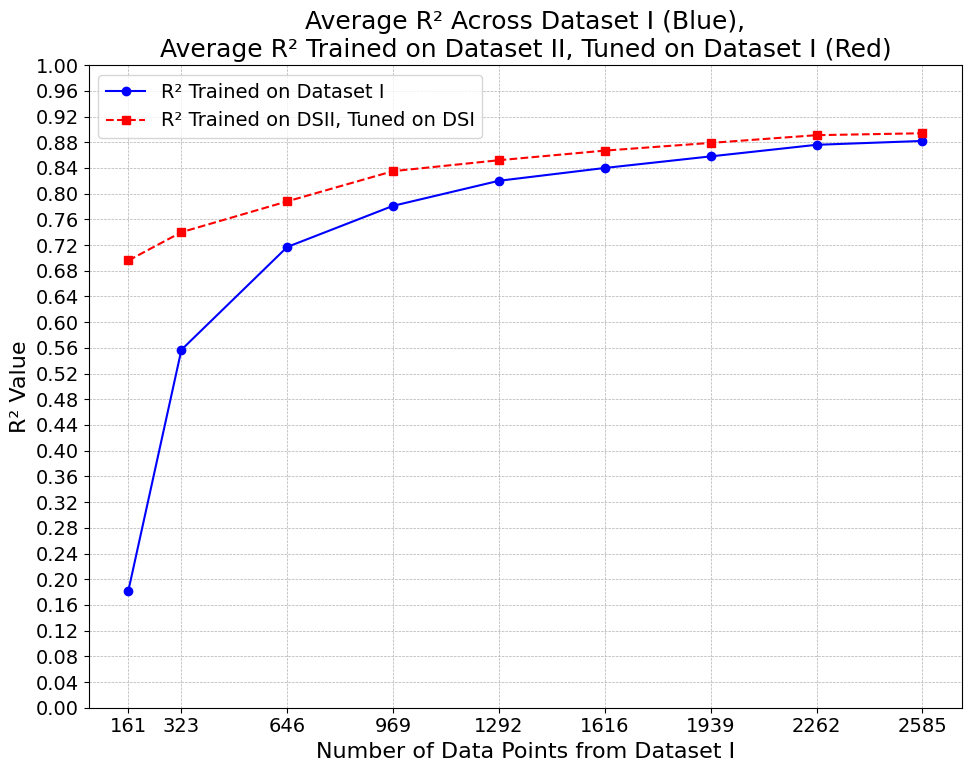

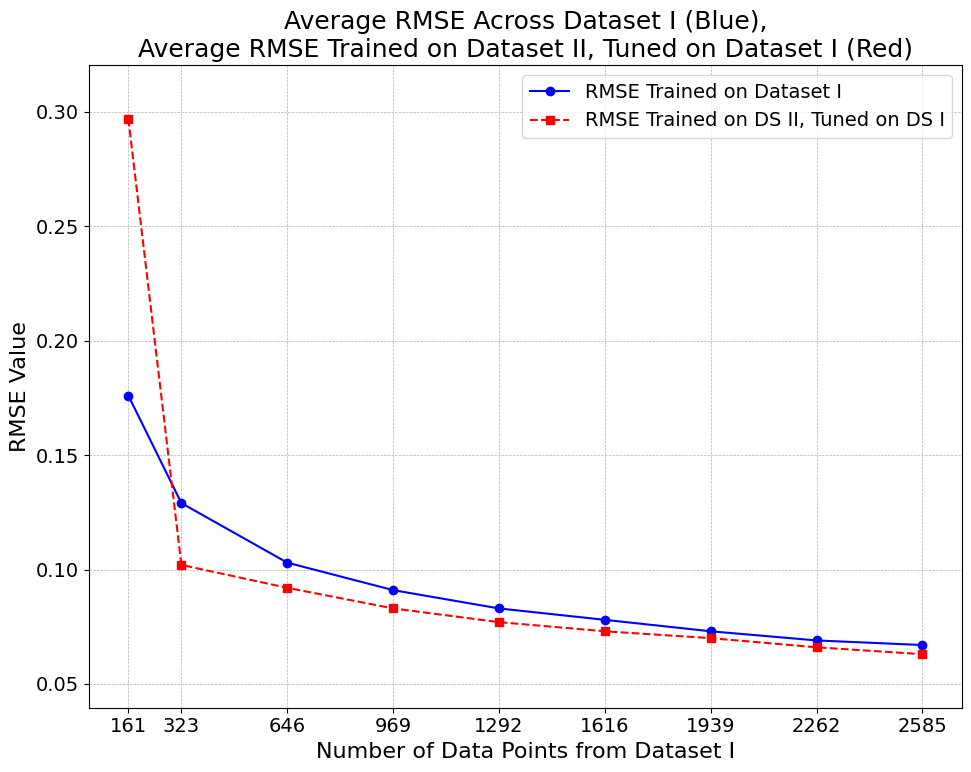

✅ Plots saved to:
/home/nishat_labiba/Research USF/Research Material Data/Results/compsequences(original)/percent_training_without_pretrained_model


In [ ]:
# Global font sizes for consistent figure styling
mpl.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
})

# Output directory
results_dir = '/home/nishat_labiba/Research USF/Research Material Data/Results/Compare Avg Metrics With and Without Pretrained Model/Compsequences(original)'
os.makedirs(results_dir, exist_ok=True)

"""
Metrics for Dataset II (these were exported to CSV in prior runs
and are pasted here directly as arrays for plotting).
"""
# Increasing Training Size
train_data_sizes = np.array([161, 323, 646, 969, 1292, 1616, 1939, 2262, 2585])

# avg r^2 and RMSE values after training on DSII and tuned on DSI -> Red line
r_squared_values = np.array([0.696, 0.740, 0.788, 0.835, 0.852, 0.867, 0.879, 0.891, 0.894])
RMSEvalues = np.array([0.297, 0.102, 0.092, 0.083, 0.077, 0.073, 0.070, 0.066, 0.063])

# avg r^2 and RMSE values after training on DSI -> Blue line
avg_r2_scores = np.array([0.182, 0.557, 0.717, 0.781, 0.820, 0.840, 0.858, 0.876, 0.882])
avg_rmse_scores = np.array([0.176, 0.129, 0.103, 0.091, 0.083, 0.078, 0.073, 0.069, 0.067])


# --- R² Plot ---
plt.figure(figsize=(10, 8))

plt.plot(train_data_sizes, avg_r2_scores, marker='o', color='blue', label='R² Trained on Dataset I')
plt.plot(train_data_sizes, r_squared_values, marker='s', linestyle='--', color='red', label='R² Trained on DSII, Tuned on DSI')

plt.title('Average R² Across Dataset I (Blue),\nAverage R² Trained on Dataset II, Tuned on Dataset I (Red)')
plt.xlabel('Number of Data Points from Dataset I')
plt.ylabel('R² Value')
plt.ylim(0.0, 1.0)

plt.xticks(train_data_sizes)
plt.yticks(np.arange(0, 1.02, 0.04))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f'{results_dir}/combined_avg_r2_scores_d2_to_d1.png')
plt.show()

# --- RMSE Plot ---
y_min = min(RMSEvalues.min(), avg_rmse_scores.min())
y_max = max(RMSEvalues.max(), avg_rmse_scores.max())
y_margin = (y_max - y_min) * 0.1

plt.figure(figsize=(10, 8))

plt.plot(train_data_sizes, avg_rmse_scores, marker='o', color='blue', label='RMSE Trained on Dataset I')
plt.plot(train_data_sizes, RMSEvalues, marker='s', linestyle='--', color='red', label='RMSE Trained on DS II, Tuned on DS I')

plt.title('Average RMSE Across Dataset I (Blue),\nAverage RMSE Trained on Dataset II, Tuned on Dataset I (Red)')
plt.xlabel('Number of Data Points from Dataset I')
plt.ylabel('RMSE Value')
plt.ylim(y_min - y_margin, y_max + y_margin)

plt.xticks(train_data_sizes)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

save_path = os.path.join(results_dir, 'combined_avg_rmse_scores_d2_to_d1_zoomed.png')
plt.savefig(save_path)
plt.show()

print(f"✅ Plots saved to:\n{results_dir}")